In [1]:
import torch.nn as nn
import torch
import numpy as np
import os
os.system('ulimit -n 1024')
import sys
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

cwd_dir = (os.path.abspath(os.path.join(os.getcwd())))
sys.path.insert(0, cwd_dir)
from utils.model import UNetWithAttention
from utils.utils3 import *
import utils.constants as constants

import matplotlib.pyplot as plt

In [ ]:
first_month = (1979, 10)
last_month = (1980, 9)
train_test = 0.2

In [ ]:
domain1 = 28
domain2 = 29

train1_dataloader, test1_dataloader = generate_dataloaders(domain1, first_month, last_month, train_test)
train2_dataloader, test2_dataloader = generate_dataloaders(domain2, first_month, last_month, train_test)

In [ ]:
import matplotlib.pyplot as plt

torch.manual_seed(42)

for i in range(3):
    # Load the first sample from the first domain
    input1, target1, times1 = next(iter(train1_dataloader))
    input1, target1, times1 = input1[0], target1[0], times1[0]
    # convert times1 from timestamp to numpy datetime64
    times1 = np.datetime64(datetime.utcfromtimestamp(times1.item()))

    input2, target2, times2 = next(iter(train2_dataloader))
    input2, target2, times2 = input2[0], target2[0], times2[0]
    # convert times2 from timestamp to numpy datetime64
    times2 = np.datetime64(datetime.utcfromtimestamp(times2.item()))

    edge1 = target1[:, -1]
    edge2 = target2[:, 0]

    # find mse between edge1 and edge2
    mse = nn.MSELoss()
    loss = mse(edge1, edge2)

    input = np.concatenate([input1, input2], axis=1)
    target = np.concatenate([target1, target2], axis=1)

    # plot just the input (no subplot)
    plt.imshow(target, vmin=0, vmax=1)
    # add a line at the edg1 and edge2
    plt.axis('off')
    plt.show()

    print(times1)
    print(times2)
    print(loss.item())

In [ ]:
one_to_two_relationship = 'left'

model1 = UNetWithAttention(1, 1, output_shape=(64,64)).to(constants.device).eval()
model2 = UNetWithAttention(1, 1, output_shape=(64,64)).to(constants.device).eval()

checkpoint1 = torch.load(f'{constants.checkpoints_dir}{domain1}/1_model.pt')
model1.load_state_dict(checkpoint1['model_state_dict'])

checkpoint2 = torch.load(f'{constants.checkpoints_dir}{domain2}/1_model.pt')
model2.load_state_dict(checkpoint2['model_state_dict'])

print('weights loaded')

# test1_dataloader
# test2_dataloader

# for i, (inputs, targets, times) in tqdm(enumerate(test1_dataloader), total=len(test1_dataloader)):

target_edge_losses = []
output_edge_losses = []

for i, ((inputs1, targets1, times1), (inputs2, targets2, times2)) in tqdm(enumerate(zip(test1_dataloader, test2_dataloader)), total=len(test1_dataloader)):

    inputs1, targets1 = inputs1.to(constants.device), targets1.to(constants.device)
    inputs2, targets2 = inputs2.to(constants.device), targets2.to(constants.device)

    outputs1 = model1(inputs1)
    outputs2 = model2(inputs2)

    if one_to_two_relationship == 'left':
        domain1_target_edge = targets1[:, :, -1]
        domain2_target_edge = targets2[:, :, 0]
        domain1_output_edge = outputs1[:, :, -1]
        domain2_output_edge = outputs2[:, :, 0]

    edge_loss = nn.MSELoss()
    target_edge_loss = edge_loss(domain1_target_edge, domain2_target_edge).item()
    output_edge_loss = edge_loss(domain1_output_edge, domain2_output_edge).item()

    target_edge_losses.append(target_edge_loss)
    output_edge_losses.append(output_edge_loss)

print(np.mean(target_edge_losses))
print(np.mean(output_edge_losses))

28 left
weights loaded
['1980-07-25T21:00:00' '1979-10-25T15:00:00' '1980-07-15T12:00:00']
['1980-07-25T21:00:00' '1979-10-25T15:00:00' '1980-07-15T12:00:00']
dataloaders generated


  0%|          | 0/19 [00:00<?, ?it/s]

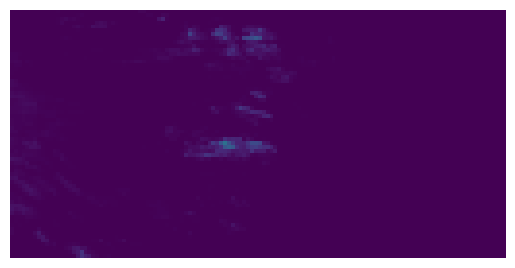

  5%|▌         | 1/19 [00:00<00:16,  1.08it/s]

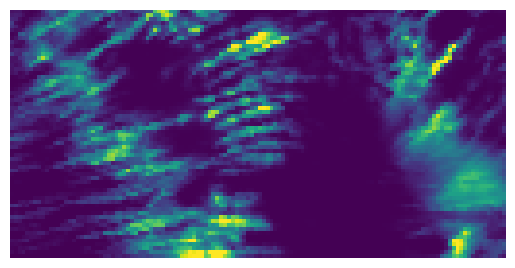

 11%|█         | 2/19 [00:02<00:19,  1.17s/it]

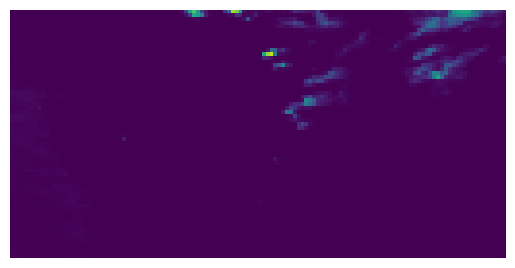

 16%|█▌        | 3/19 [00:03<00:17,  1.09s/it]

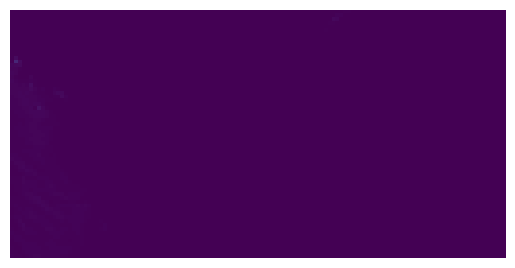

 21%|██        | 4/19 [00:03<00:12,  1.23it/s]

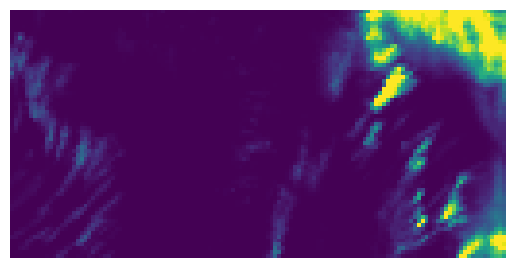

 26%|██▋       | 5/19 [00:04<00:09,  1.53it/s]

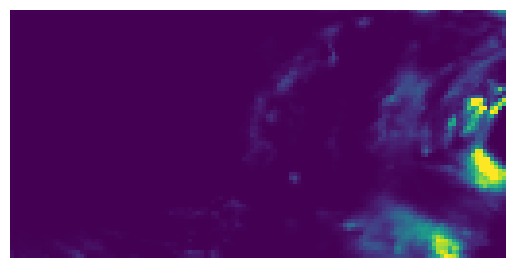

 32%|███▏      | 6/19 [00:04<00:07,  1.78it/s]

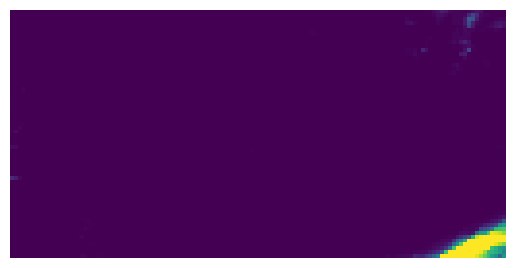

 37%|███▋      | 7/19 [00:04<00:06,  1.98it/s]

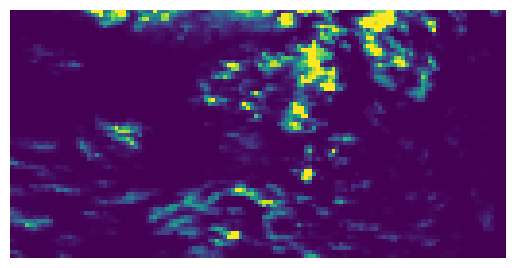

 42%|████▏     | 8/19 [00:05<00:05,  2.15it/s]

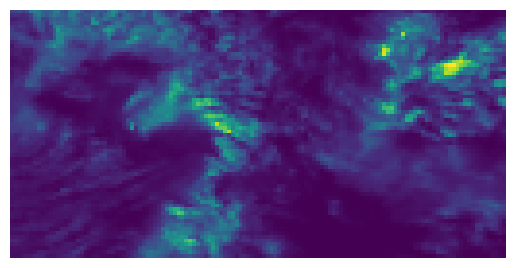

 47%|████▋     | 9/19 [00:05<00:04,  2.27it/s]

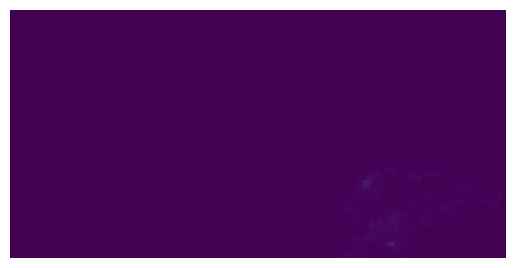

 53%|█████▎    | 10/19 [00:05<00:03,  2.38it/s]

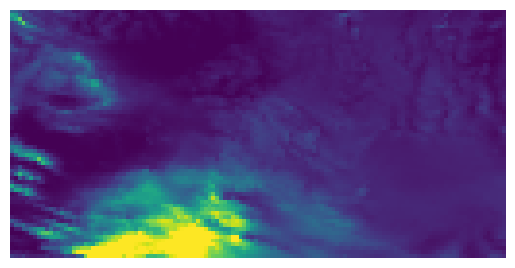

 58%|█████▊    | 11/19 [00:06<00:03,  2.45it/s]

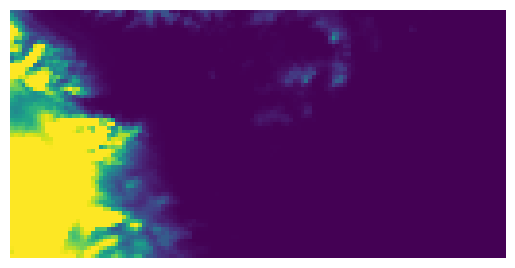

 63%|██████▎   | 12/19 [00:06<00:02,  2.44it/s]

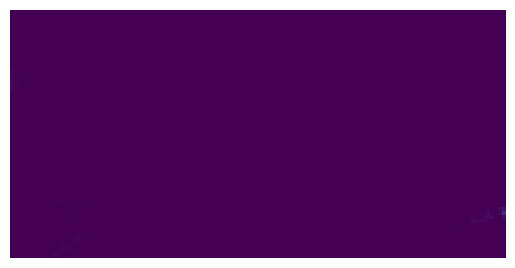

 68%|██████▊   | 13/19 [00:07<00:02,  2.45it/s]

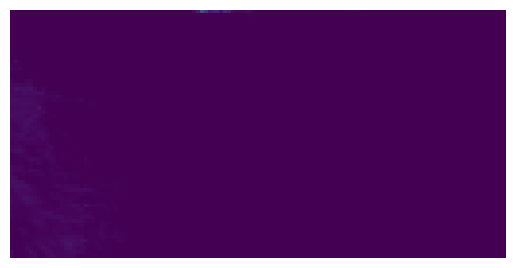

 74%|███████▎  | 14/19 [00:07<00:02,  2.45it/s]

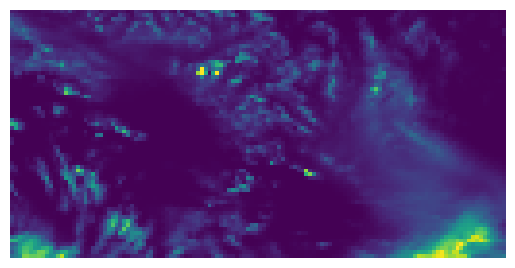

 79%|███████▉  | 15/19 [00:07<00:01,  2.44it/s]

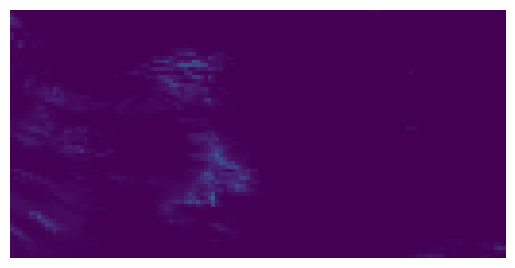

 84%|████████▍ | 16/19 [00:08<00:01,  2.42it/s]

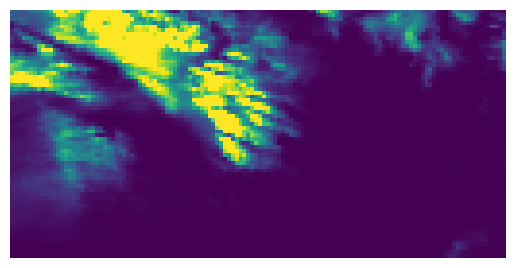

 89%|████████▉ | 17/19 [00:08<00:00,  2.47it/s]

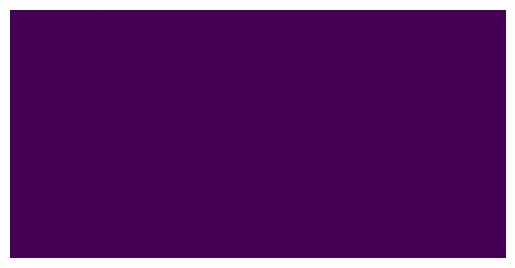

 95%|█████████▍| 18/19 [00:09<00:00,  2.53it/s]

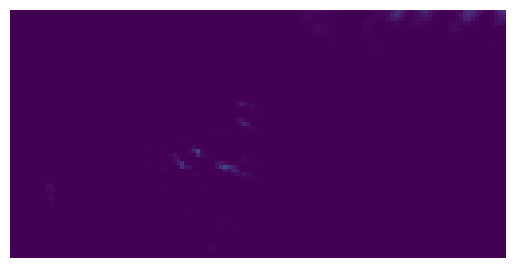

100%|██████████| 19/19 [00:09<00:00,  2.00it/s]


0.19087518575160126
0.20395652028290848

30 right
weights loaded
['1980-07-25T21:00:00' '1979-10-25T15:00:00' '1980-07-15T12:00:00']
['1980-07-25T21:00:00' '1979-10-25T15:00:00' '1980-07-15T12:00:00']
dataloaders generated


  0%|          | 0/19 [00:00<?, ?it/s]

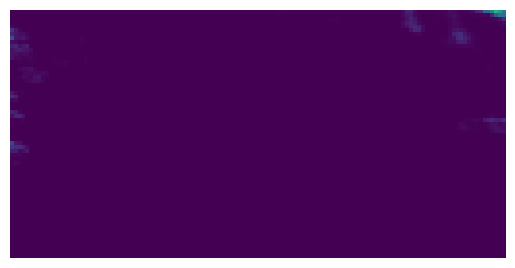

  5%|▌         | 1/19 [00:03<01:00,  3.38s/it]

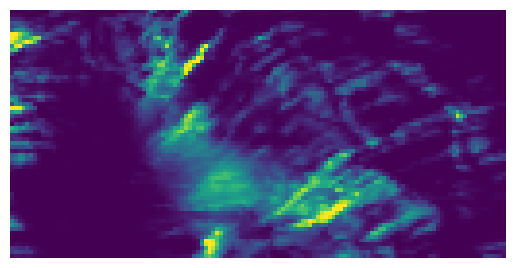

 11%|█         | 2/19 [00:04<00:36,  2.15s/it]

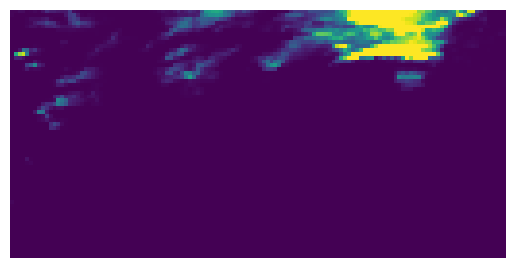

 16%|█▌        | 3/19 [00:05<00:21,  1.36s/it]

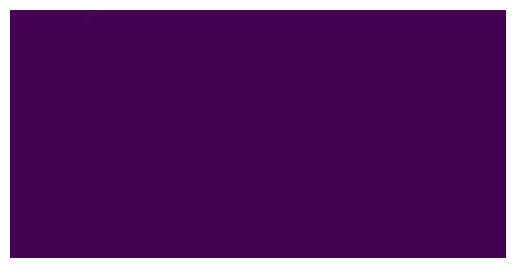

 21%|██        | 4/19 [00:05<00:14,  1.03it/s]

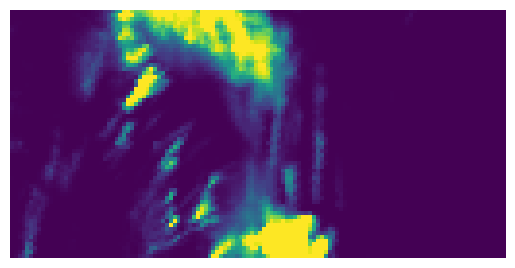

 26%|██▋       | 5/19 [00:05<00:10,  1.31it/s]

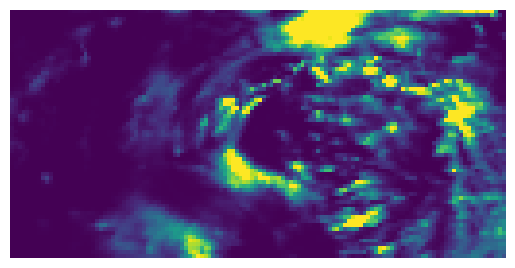

 32%|███▏      | 6/19 [00:06<00:08,  1.57it/s]

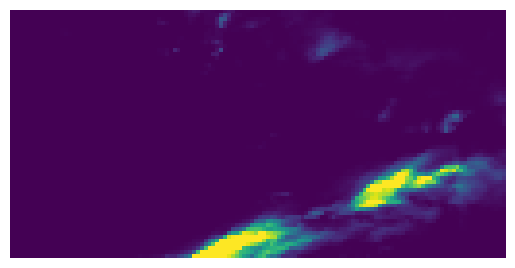

 37%|███▋      | 7/19 [00:06<00:06,  1.80it/s]

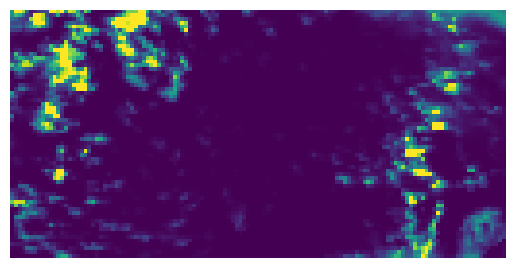

 42%|████▏     | 8/19 [00:07<00:05,  2.00it/s]

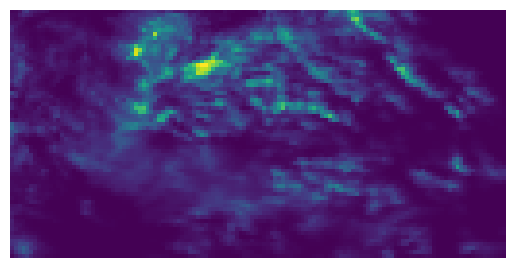

 47%|████▋     | 9/19 [00:07<00:04,  2.17it/s]

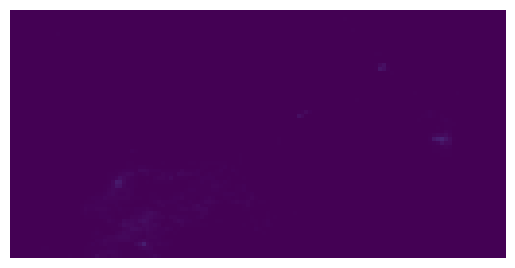

 53%|█████▎    | 10/19 [00:07<00:03,  2.29it/s]

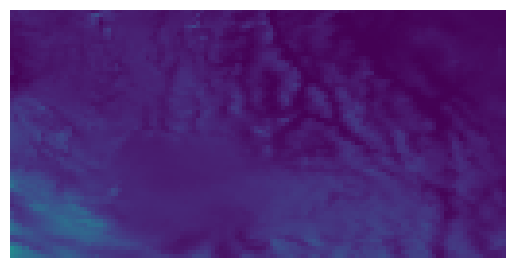

 58%|█████▊    | 11/19 [00:08<00:03,  2.37it/s]

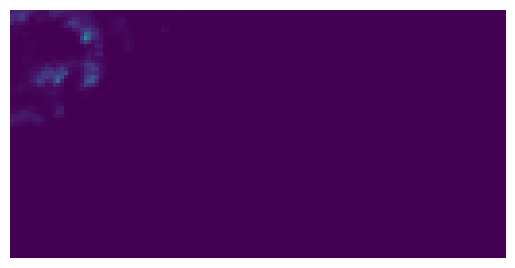

 63%|██████▎   | 12/19 [00:08<00:02,  2.44it/s]

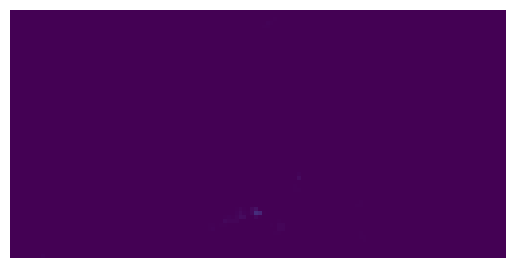

 68%|██████▊   | 13/19 [00:08<00:02,  2.49it/s]

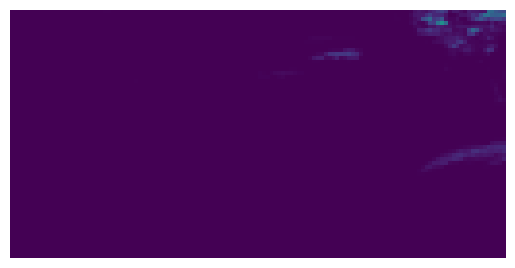

 74%|███████▎  | 14/19 [00:09<00:01,  2.53it/s]

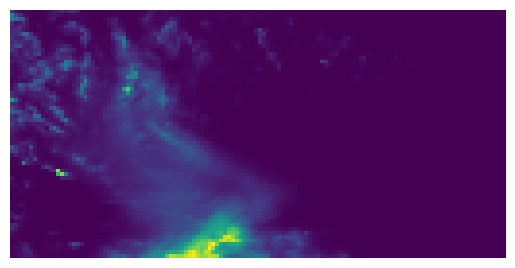

 79%|███████▉  | 15/19 [00:09<00:01,  2.56it/s]

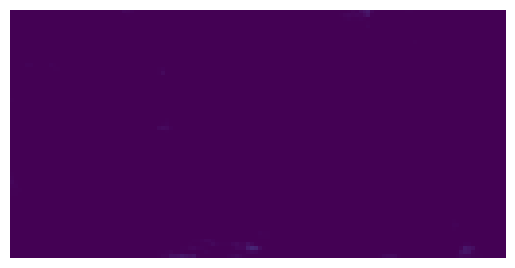

 84%|████████▍ | 16/19 [00:10<00:01,  2.57it/s]

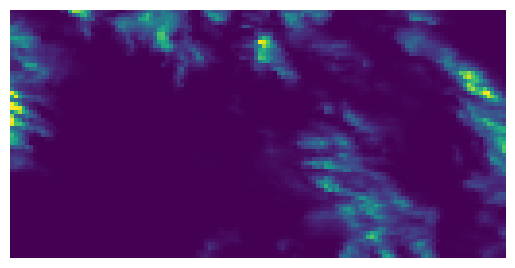

 89%|████████▉ | 17/19 [00:10<00:00,  2.60it/s]

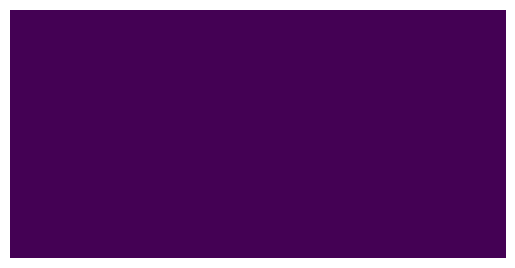

 95%|█████████▍| 18/19 [00:10<00:00,  2.62it/s]

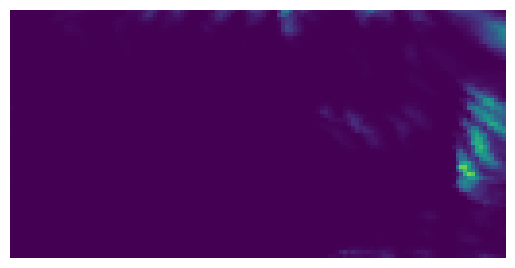

100%|██████████| 19/19 [00:10<00:00,  1.73it/s]


0.08570293190055772
0.181194416786495

36 above
weights loaded
['1980-07-25T21:00:00' '1979-10-25T15:00:00' '1980-07-15T12:00:00']
['1980-07-25T21:00:00' '1979-10-25T15:00:00' '1980-07-15T12:00:00']
dataloaders generated


  0%|          | 0/19 [00:00<?, ?it/s]

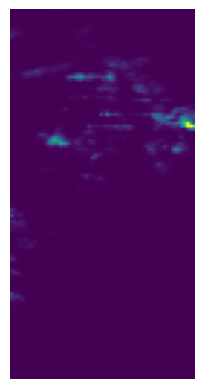

  5%|▌         | 1/19 [00:03<01:11,  3.96s/it]

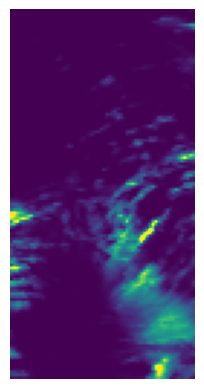

 11%|█         | 2/19 [00:04<00:31,  1.87s/it]

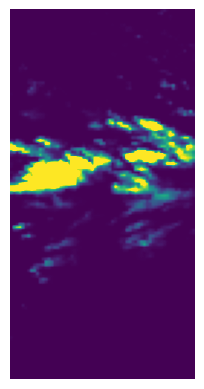

 16%|█▌        | 3/19 [00:04<00:20,  1.28s/it]

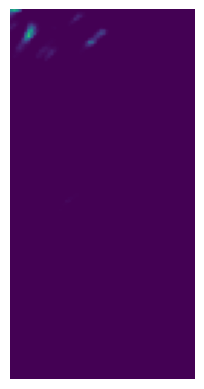

 21%|██        | 4/19 [00:05<00:13,  1.08it/s]

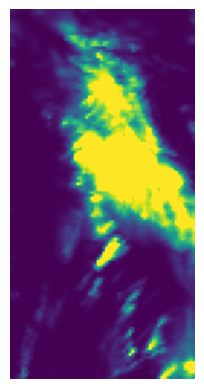

 26%|██▋       | 5/19 [00:05<00:10,  1.32it/s]

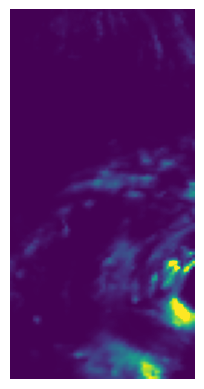

 32%|███▏      | 6/19 [00:06<00:08,  1.58it/s]

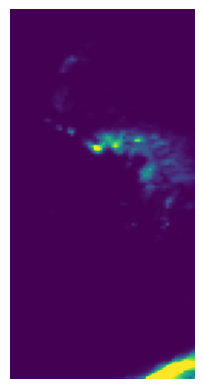

 37%|███▋      | 7/19 [00:06<00:07,  1.69it/s]

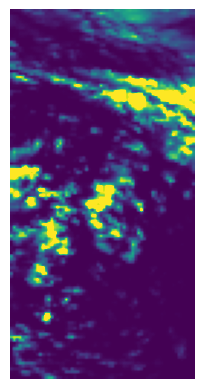

 42%|████▏     | 8/19 [00:07<00:05,  1.90it/s]

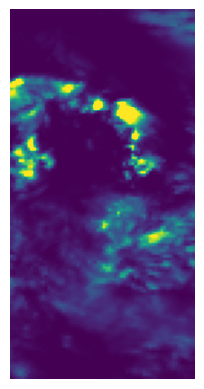

 47%|████▋     | 9/19 [00:07<00:05,  1.97it/s]

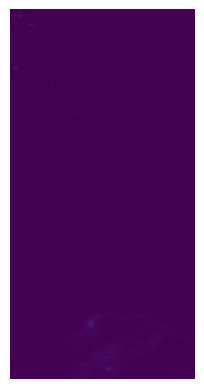

 53%|█████▎    | 10/19 [00:07<00:04,  2.14it/s]

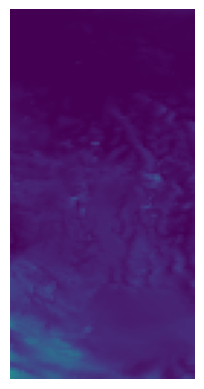

 58%|█████▊    | 11/19 [00:08<00:04,  1.75it/s]

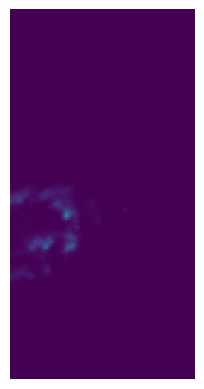

 63%|██████▎   | 12/19 [00:09<00:03,  1.93it/s]

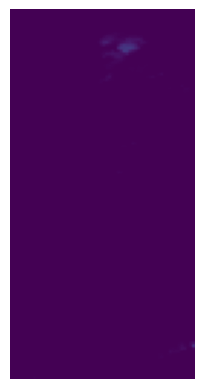

 68%|██████▊   | 13/19 [00:10<00:04,  1.35it/s]

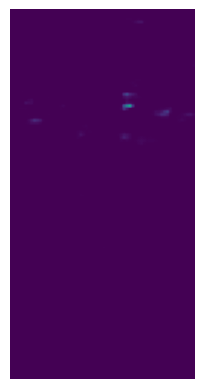

 74%|███████▎  | 14/19 [00:10<00:03,  1.56it/s]

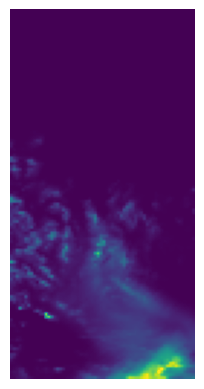

 79%|███████▉  | 15/19 [00:11<00:02,  1.47it/s]

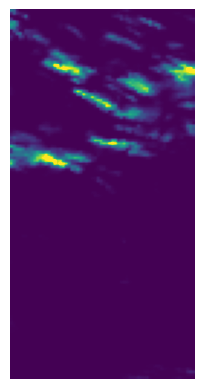

 84%|████████▍ | 16/19 [00:11<00:01,  1.68it/s]

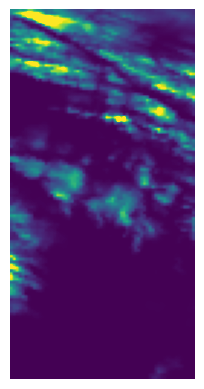

 89%|████████▉ | 17/19 [00:12<00:01,  1.62it/s]

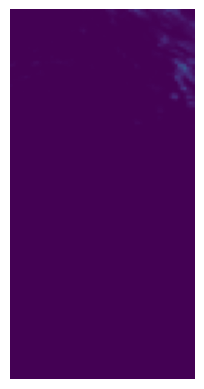

 95%|█████████▍| 18/19 [00:13<00:00,  1.83it/s]

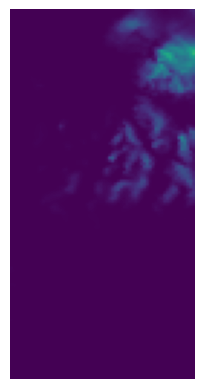

100%|██████████| 19/19 [00:13<00:00,  1.44it/s]


0.1401712568966966
0.06807706044300606

22 below
weights loaded
['1980-07-25T21:00:00' '1979-10-25T15:00:00' '1980-07-15T12:00:00']
['1980-07-25T21:00:00' '1979-10-25T15:00:00' '1980-07-15T12:00:00']
dataloaders generated


  0%|          | 0/19 [00:00<?, ?it/s]

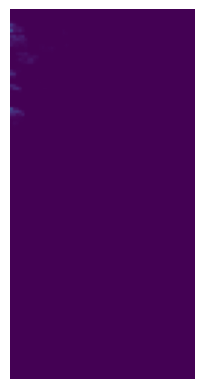

  5%|▌         | 1/19 [00:02<00:37,  2.07s/it]

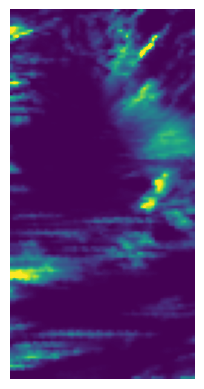

 11%|█         | 2/19 [00:02<00:18,  1.10s/it]

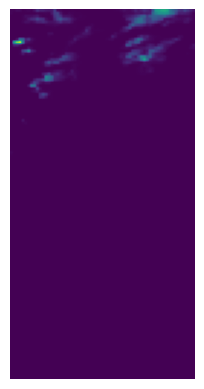

 16%|█▌        | 3/19 [00:02<00:12,  1.27it/s]

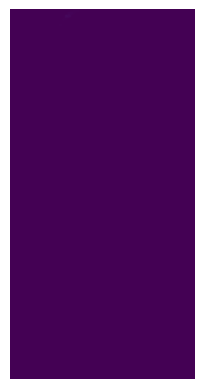

 21%|██        | 4/19 [00:03<00:09,  1.60it/s]

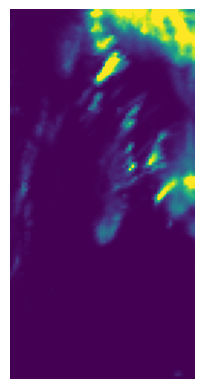

 26%|██▋       | 5/19 [00:03<00:08,  1.62it/s]

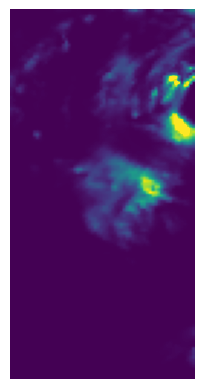

 32%|███▏      | 6/19 [00:04<00:08,  1.46it/s]

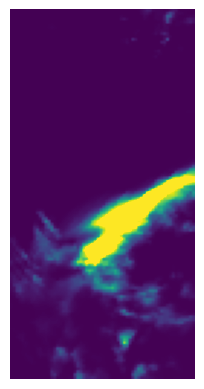

 37%|███▋      | 7/19 [00:05<00:07,  1.57it/s]

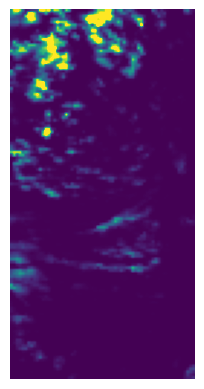

 42%|████▏     | 8/19 [00:05<00:06,  1.65it/s]

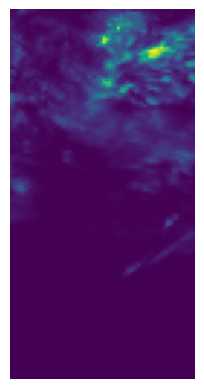

 47%|████▋     | 9/19 [00:06<00:05,  1.78it/s]

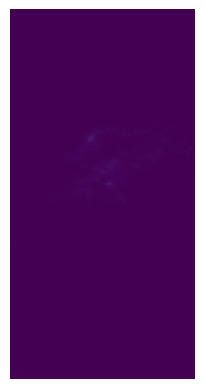

 53%|█████▎    | 10/19 [00:06<00:04,  1.90it/s]

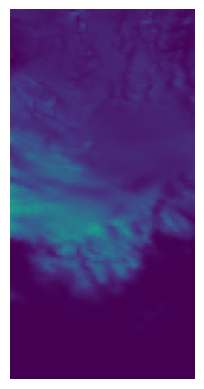

 58%|█████▊    | 11/19 [00:07<00:04,  1.98it/s]

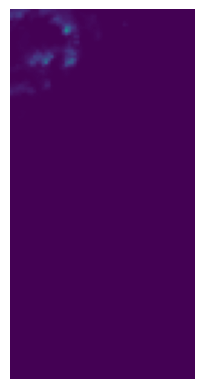

 63%|██████▎   | 12/19 [00:07<00:03,  2.10it/s]

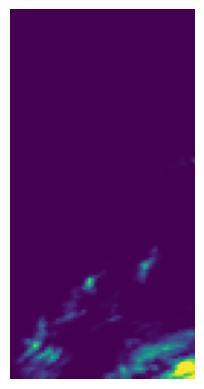

 68%|██████▊   | 13/19 [00:08<00:02,  2.10it/s]

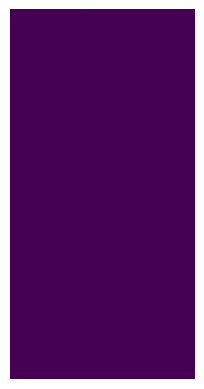

 74%|███████▎  | 14/19 [00:08<00:02,  2.22it/s]

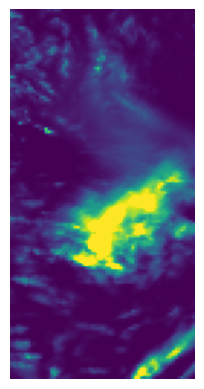

 79%|███████▉  | 15/19 [00:08<00:01,  2.09it/s]

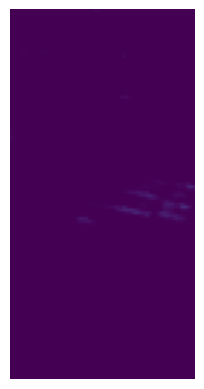

 84%|████████▍ | 16/19 [00:09<00:01,  2.00it/s]

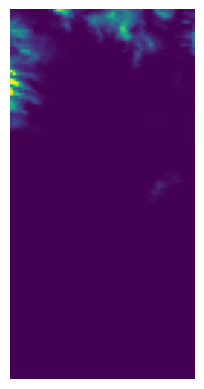

 89%|████████▉ | 17/19 [00:10<00:00,  2.01it/s]

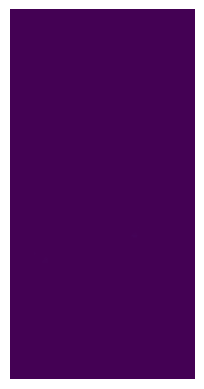

 95%|█████████▍| 18/19 [00:10<00:00,  2.14it/s]

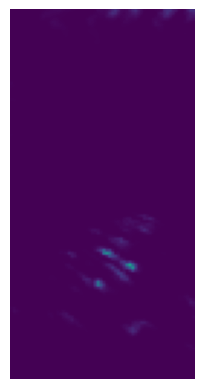

100%|██████████| 19/19 [00:10<00:00,  1.79it/s]

0.08433254146458287
0.054700077168251336



In [1]:
import torch.nn as nn
import torch
import numpy as np
import os
os.system('ulimit -n 1024')
import sys
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

cwd_dir = (os.path.abspath(os.path.join(os.getcwd())))
sys.path.insert(0, cwd_dir)
from utils.model import UNetWithAttention
from utils.utils3 import *
import utils.constants as constants

import matplotlib.pyplot as plt

def generate_dataloaders(domain, first_month, last_month, train_test):
    input_file_paths = []
    target_file_paths = []
    times_file_paths = []
    first_month = datetime(first_month[0], first_month[1], 1)
    last_month = datetime(last_month[0], last_month[1], 1)
    current_month = first_month
    while current_month <= last_month:
        input_fp = f'{constants.domains_dir}{domain}/input_{current_month.year}_{current_month.month:02d}.npy'
        target_fp = f'{constants.domains_dir}{domain}/target_{current_month.year}_{current_month.month:02d}.npy'
        times_fp = f'{constants.domains_dir}{domain}/times_{current_month.year}_{current_month.month:02d}.npy'
        input_file_paths.append(input_fp)
        target_file_paths.append(target_fp)
        times_file_paths.append(times_fp)
        current_month += relativedelta(months=1)

    input_arr = np.concatenate([np.load(fp) for fp in input_file_paths])
    target_arr = np.concatenate([np.load(fp) for fp in target_file_paths])
    times_arr = np.concatenate([np.load(fp) for fp in times_file_paths])

    times_arr = times_arr.astype('datetime64[s]').astype(np.float64)

    np.random.seed(42)
    indices = np.argsort(times_arr)
    np.random.shuffle(indices)
    input_arr = input_arr[indices]
    target_arr = target_arr[indices]
    times_arr = times_arr[indices]

    # convert the first 3 timestamps in times_arr to numpy datetime64, print them
    print(times_arr[:3].astype('datetime64[s]'))

    test_input_arr, train_input_arr = np.split(input_arr, [int(train_test * len(input_arr))])
    test_target_arr, train_target_arr = np.split(target_arr, [int(train_test * len(target_arr))])
    test_times_arr, train_times_arr = np.split(times_arr, [int(train_test * len(times_arr))])

    train_dataset = MemMapDataset(train_input_arr, train_target_arr, train_times_arr)
    test_dataset = MemMapDataset(test_input_arr, test_target_arr, test_times_arr)

    torch.manual_seed(42)
    generator = torch.Generator()
    generator.manual_seed(42)
    train_dataloader = DataLoader(train_dataset, batch_size=constants.training_batch_size, shuffle=True, generator=generator)
    test_dataloader = DataLoader(test_dataset, batch_size=constants.training_batch_size, shuffle=False)

    return train_dataloader, test_dataloader


def find_adjascent_tiles(domain):
    with open(f'{constants.domains_dir}grid_domains.pkl', 'rb') as f:
        grid_domains = pickle.load(f)
    min_lat, max_lat, min_lon, max_lon = grid_domains[domain]

    adjascent_tiles = []

    # left tile
    coordinates = [min_lat, max_lat, min_lon-4, max_lon-4]
    for domain in grid_domains:
        if grid_domains[domain] == coordinates:
            adjascent_tiles.append((domain, 'left'))

    # right tile
    coordinates = [min_lat, max_lat, min_lon+4, max_lon+4]
    for domain in grid_domains:
        if grid_domains[domain] == coordinates:
            adjascent_tiles.append((domain, 'right'))

    # above tile
    coordinates = [min_lat+4, max_lat+4, min_lon, max_lon]
    for domain in grid_domains:
        if grid_domains[domain] == coordinates:
            adjascent_tiles.append((domain, 'above'))

    # below tile
    coordinates = [min_lat-4, max_lat-4, min_lon, max_lon]
    for domain in grid_domains:
        if grid_domains[domain] == coordinates:
            adjascent_tiles.append((domain, 'below'))

    return adjascent_tiles


all_losses = {}


domain1 = 29
first_month = (1979, 10)
last_month = (1980, 9)
train_test = 0.2

adjascent_tiles = find_adjascent_tiles(domain1)

for adjascent_tile in adjascent_tiles:
    domain2, one_to_two_relationship = adjascent_tile[0], adjascent_tile[1]
    print(domain2, one_to_two_relationship)

    model1 = UNetWithAttention(1, 1, output_shape=(64,64)).to(constants.device).eval()
    model2 = UNetWithAttention(1, 1, output_shape=(64,64)).to(constants.device).eval()

    checkpoint1 = torch.load(f'{constants.checkpoints_dir}{domain1}/0_model.pt')
    model1.load_state_dict(checkpoint1['model_state_dict'])

    checkpoint2 = torch.load(f'{constants.checkpoints_dir}{domain2}/0_model.pt')
    model2.load_state_dict(checkpoint2['model_state_dict'])

    print('weights loaded')

    train1_dataloader, test1_dataloader = generate_dataloaders(domain1, first_month, last_month, train_test)
    train2_dataloader, test2_dataloader = generate_dataloaders(domain2, first_month, last_month, train_test)

    print('dataloaders generated')

    target_edge_losses = []
    output_edge_losses = []

    for i, ((inputs1, targets1, times1), (inputs2, targets2, times2)) in tqdm(enumerate(zip(test1_dataloader, test2_dataloader)), total=len(test1_dataloader)):

        inputs1, targets1 = inputs1.to(constants.device), targets1.to(constants.device)
        inputs2, targets2 = inputs2.to(constants.device), targets2.to(constants.device)

        outputs1 = model1(inputs1)
        outputs2 = model2(inputs2)

        if one_to_two_relationship == 'left':
            combined_target = np.concatenate([targets2.detach().cpu().numpy(), targets1.detach().cpu().numpy()], axis=2)
            combined_output = np.concatenate([outputs2.detach().cpu().numpy(), outputs1.detach().cpu().numpy()], axis=2)

            domain1_target_edge = targets1[:, :, 0]
            domain2_target_edge = targets2[:, :, -1]
            domain1_output_edge = outputs1[:, :, 0]
            domain2_output_edge = outputs2[:, :, -1]
        elif one_to_two_relationship == 'right':
            combined_target = np.concatenate([targets1.detach().cpu().numpy(), targets2.detach().cpu().numpy()], axis=2)
            combined_output = np.concatenate([outputs1.detach().cpu().numpy(), outputs2.detach().cpu().numpy()], axis=2)

            domain1_target_edge = targets1[:, :, -1]
            domain2_target_edge = targets2[:, :, 0]
            domain1_output_edge = outputs1[:, :, -1]
            domain2_output_edge = outputs2[:, :, 0]
        elif one_to_two_relationship == 'above':
            combined_target = np.concatenate([targets1.detach().cpu().numpy(), targets2.detach().cpu().numpy()], axis=1)
            combined_output = np.concatenate([outputs1.detach().cpu().numpy(), outputs2.detach().cpu().numpy()], axis=1)

            domain1_target_edge = targets1[:, -1, :]
            domain2_target_edge = targets2[:, 0, :]
            domain1_output_edge = outputs1[:, -1, :]
            domain2_output_edge = outputs2[:, 0, :]
        elif one_to_two_relationship == 'below':
            combined_target = np.concatenate([targets2.detach().cpu().numpy(), targets1.detach().cpu().numpy()], axis=1)
            combined_output = np.concatenate([outputs2.detach().cpu().numpy(), outputs1.detach().cpu().numpy()], axis=1)

            domain1_target_edge = targets1[:, 0, :]
            domain2_target_edge = targets2[:, -1, :]
            domain1_output_edge = outputs1[:, 0, :]
            domain2_output_edge = outputs2[:, -1, :]

        edge_loss = nn.MSELoss()
        target_edge_loss = edge_loss(domain1_target_edge, domain2_target_edge).item()
        output_edge_loss = edge_loss(domain1_output_edge, domain2_output_edge).item()

        target_edge_losses.append(target_edge_loss)
        output_edge_losses.append(output_edge_loss)

    print(np.mean(target_edge_losses))
    print(np.mean(output_edge_losses))
    print()